# NLP Series P1, Shapley and Interpretability is a must!
Disclaimer, for the sake of keeping these posts relatively short, I will not be conducting robust model validation, or using more advanced NLP techniques. This is purely to show a simple NLP multi-class classification task, and how we can
interpret the results. 

Trying to convince your stakeholder that your model is a black box of magic that they can simply trust is, understandably, a hard sell. Shapley values are an absolute must and in my professional experience have been responsible for major buy in to a modeling effort. 

Were going to do multi-class text classification, with 4 classes, show how to do summary plots, interpret an example for each of the 4 categories, and then show how an ambiguous sample is interpreted by all 4 classes.

To run this code you should use the requirements.txt as the versions of some packages are extremely important, and copy the model folder with the torch dense neural net implementation

Dataset: https://www.kaggle.com/datasets/tunguz/200000-jeopardy-questions

In [484]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from torch.nn.functional import softmax
import shap
from models.nn_model_tfidf import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Lets grab a csv containing historical information from the show jeapordy. Each Question belongs to a Category.
df = pd.read_csv('JEOPARDY_CSV.csv')
#Some of the columns come with odd names so lets strip white spaces before and after
df.rename(columns = {x:x.lstrip().rstrip() for x in df.columns}, inplace=True) 
df = df[['Question','Category']]
df.Category.value_counts().head(10)

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
Name: Category, dtype: int64

As we can see there are many many categories and they are all relatively small.

Lets create 4 categories by combining others: 
History, Literature, Art, and Geography

In [3]:
#rename_cols = 
df.rename(columns = {x:x.lstrip().rstrip() for x in df.columns}, inplace=True) #EDA found spaces before and after column names
#Lets make some categories with 1500 observations each
df.Category.replace({'WORLD HISTORY':'HISTORY','AMERICAN HISTORY':'HISTORY','U.S. HISTORY':'HISTORY','THE CIVIL WAR':'HISTORY'},inplace=True)
df.Category.replace({'U.S. GEOGRAPHY':'GEOGRAPHY','WORLD GEOGRAPHY':'GEOGRAPHY',
                    'BODIES OF WATER':'GEOGRAPHY','ISLANDS':'GEOGRAPHY'},inplace=True)
df.Category.replace({'BOOKS & AUTHORS':'LITERATURE','SHAKESPEARE':'LITERATURE','FICTIONAL CHARACTERS':'LITERATURE','AMERICAN LITERATURE':'LITERATURE'},inplace=True)
df.Category.replace({'U.S. CITIES':'CITY_COUNTRY','STATE CAPITALS':'CITY_COUNTRY','WORLD CAPITALS':'CITY_COUNTRY'},inplace=True)
df.Category.replace({'ART & ARTISTS':'ART','BALLET':'ART','OPERA':'ART','MUSIC':'ART',
                    'CLASSICAL MUSIC':'ART'},inplace=True)
df = df[df.Category.isin(['HISTORY', 'LITERATURE', 'ART', 'GEOGRAPHY'])]
df.Category.value_counts()

HISTORY       1600
LITERATURE    1559
ART           1542
GEOGRAPHY     1507
Name: Category, dtype: int64

# Lemmatizing and Speed
For a larger dataset I would suggest using the package pandarallel or using multiprocessing with an entire column at once as lemmatizing is known to be a slow process on large datasets. Mostly because it involves repeatedly using lookup tables for every word.
Given this dataset is under 10,000 rows, lemmatizing is still quite fast.

In [4]:
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()
# Two functions to do some basic cleaning, stripping odd characters and numbers, leaving alpha numeric.
def basic_clean(text):
    "Strips all non-alpha numeric text"
    # Regex pattern for only alphanumeric, hyphenated text
    return(re.sub(r'[^a-zA-Z -]', '', text))

def pre_processing(text):
    '''
    Tokenizes, Lemmatizes, Lower Cases, Removes Stopwords
    Joins back to Sentance'''
    lemma_list = ' '.join([wnl.lemmatize(x.lower()) for x in word_tokenize(text) if x.lower() not in stop_words])
    return lemma_list

df['clean'] = df['Question'].apply(basic_clean).apply(pre_processing)

# Split Data
In another tutorial i'll show how to better analyse results from a multi-class classification

In [210]:
#Label encoder for the the response variable
#Lets make the train and valid each 15% of the dataset
le = LabelEncoder().fit(df['Category'])
df['encoded'] = le.transform(df['Category'])
X_train, X_test, y_train, y_test = train_test_split(df['clean'], df['encoded'], test_size=.2, random_state=42,stratify=df['encoded'])

# Very basic NLP algorithm
Convert to a tfidf matrix with 100 features, feed it into a 128,64,32 dense neural net with 4 classes using torch
Then 

#Vectorize to a tf-idf matrix
max_features = 300
X_test_original = X_test.copy() #We save this tfidf matrix for the intepretation portion of this analysis
tfidf = TfidfVectorizer(max_features=max_features)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
feature_names = tfidf.get_feature_names_out ()

In [212]:
X_train = torch.tensor(X_train.todense()).to(device).float()
X_test = torch.tensor(X_test.todense()).to(device).float()

y_train = torch.tensor(y_train.values).to(device).float()
y_test = torch.tensor(y_test.values).to(device).float()

In [213]:
train_dataset = TFIDFDataset(X_train,y_train)
test_dataset = TFIDFDataset(X_test,y_test)

train_loader = DataLoader(dataset = train_dataset, batch_size = 32)
test_loader = DataLoader(dataset = test_dataset, batch_size = 16)

In [90]:
dataiter = iter(train_loader)
train_feat_ex, train_label_ex = dataiter.next()

In [91]:
model = dense_model(hidden_layers= [128,64,43], num_features = max_features, num_classes = len(le.classes_), p_drop=.15)

Again, this is a fairly small dataset and a non-robust cross validation procedure so these results are to be taken with a grain of salt, the point here is to highlight interpretation techniques, not performance

In [92]:
model, stats = train_nn(model, train_loader, test_loader, NUM_EPOCHS = 50, LR = .0001, LR_patience=5, early_stopping_callback= EarlyStoppingCallback())

  2%|█▋                                                                                 | 1/50 [00:00<00:43,  1.11it/s]

EPOCH 001: Loss: [Train: 1.36238 | test 1.24256 ] Accuracy: [Train: 31.964 | test 49.038] LR: 0.0001


  4%|███▎                                                                               | 2/50 [00:01<00:45,  1.05it/s]

EPOCH 002: Loss: [Train: 1.19640 | test 1.09368 ] Accuracy: [Train: 49.546 | test 64.103] LR: 0.0001


  6%|████▉                                                                              | 3/50 [00:02<00:43,  1.07it/s]

EPOCH 003: Loss: [Train: 1.04410 | test 0.94591 ] Accuracy: [Train: 61.679 | test 71.554] LR: 0.0001


  8%|██████▋                                                                            | 4/50 [00:03<00:43,  1.06it/s]

EPOCH 004: Loss: [Train: 0.92014 | test 0.84137 ] Accuracy: [Train: 68.717 | test 75.689] LR: 0.0001


 10%|████████▎                                                                          | 5/50 [00:04<00:41,  1.08it/s]

Message from callback (Early Stopping) counter: 1/5
no
EPOCH 005: Loss: [Train: 0.81978 | test 0.75311 ] Accuracy: [Train: 72.583 | test 77.420] LR: 0.0001


 12%|█████████▉                                                                         | 6/50 [00:05<00:40,  1.09it/s]

EPOCH 006: Loss: [Train: 0.72940 | test 0.68310 ] Accuracy: [Train: 75.935 | test 78.141] LR: 0.0001


 14%|███████████▌                                                                       | 7/50 [00:06<00:38,  1.11it/s]

Message from callback (Early Stopping) counter: 1/5
no
EPOCH 007: Loss: [Train: 0.66856 | test 0.63342 ] Accuracy: [Train: 77.958 | test 78.622] LR: 0.0001


 16%|█████████████▎                                                                     | 8/50 [00:07<00:37,  1.12it/s]

Message from callback (Early Stopping) counter: 2/5
no
EPOCH 008: Loss: [Train: 0.62259 | test 0.63164 ] Accuracy: [Train: 80.195 | test 78.990] LR: 1e-05


 18%|██████████████▉                                                                    | 9/50 [00:08<00:36,  1.12it/s]

Message from callback (Early Stopping) counter: 3/5
no
EPOCH 009: Loss: [Train: 0.61857 | test 0.62941 ] Accuracy: [Train: 80.442 | test 78.429] LR: 1e-05


 20%|████████████████▍                                                                 | 10/50 [00:09<00:36,  1.11it/s]

Message from callback (Early Stopping) counter: 4/5
no
EPOCH 010: Loss: [Train: 0.60936 | test 0.62494 ] Accuracy: [Train: 80.863 | test 79.151] LR: 1e-05


 20%|████████████████▍                                                                 | 10/50 [00:10<00:40,  1.00s/it]

Message from callback (Early Stopping) counter: 5/5
here
Training stopped -> Eearly Stopping Callback : test_loss: 0.6211988784563847


For the Shap package, deep explainer generally works fairly quick to nn.torch problems that arnt image classification

In [145]:
explainer = shap.DeepExplainer(model, shap.sample(X_test,25))
# Get the shap values from my test data
shap_values = explainer.shap_values(X_test)

In [447]:
%matplotlib inline

# Functions to generate plots
Worth noting that the title option on shap plots is buggy, so we turn it off, add it manually matplotlib

In [478]:
def summary(feature):
    encoded = le.transform([feature])[0]
    shap.summary_plot(shap_values[encoded],X_test.cpu(), feature_names=feature_names, class_names=le.classes_,show=False)
    plt.title(feature,fontsize=16)
    plt.savefig(feature,bbox_inches='tight')
    plt.close()
    
def specific_example(feature,threshold,sample_num, save_fig = False):
    encoded = le.transform([feature])[0]
    sample_index = np.where(y_test.cpu().numpy()==encoded)[0][sample_num]
    shap_vals = shap_values[encoded][sample_index]
    use = shap_vals*[abs(shap_vals)>threshold][0]
    shap.bar_plot(use,feature_names=feature_names,max_display=(abs(use)>0).sum(),show=False)
    sentence  = df.loc[X_test_original.index[sample_index],'Question']
    plt.title(f'{feature} sample: "{sentence}"')
    if save_fig:
        plt.savefig(feature+'_barplot',bbox_inches='tight')
    plt.close()

# Create Summary plot for all 4 classes

In [477]:
for feature in le.classes_[:]:
    summary(feature)

# Picked some specific examples that are interesting to look at

In [479]:
specific_example('ART',.1,3, save_fig=True)
specific_example('HISTORY', .1, 1, save_fig=True)
specific_example('GEOGRAPHY', .1, 5, save_fig=True)
specific_example('LITERATURE', .1, 9, save_fig=True)

# Pick one specific interesting case and see how each category interprets it

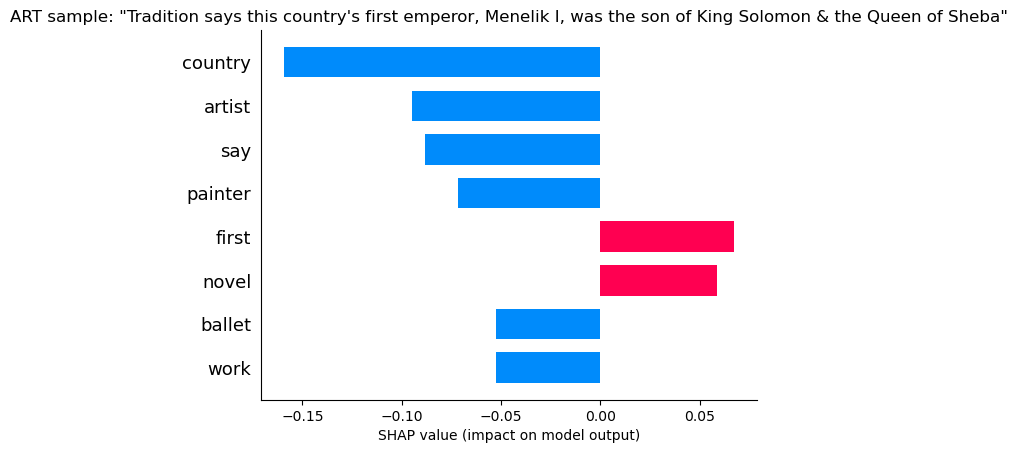

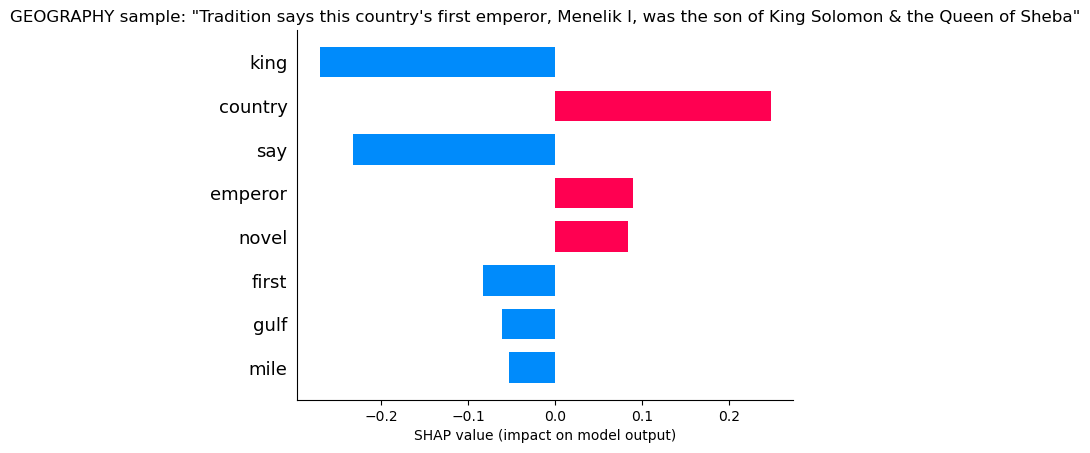

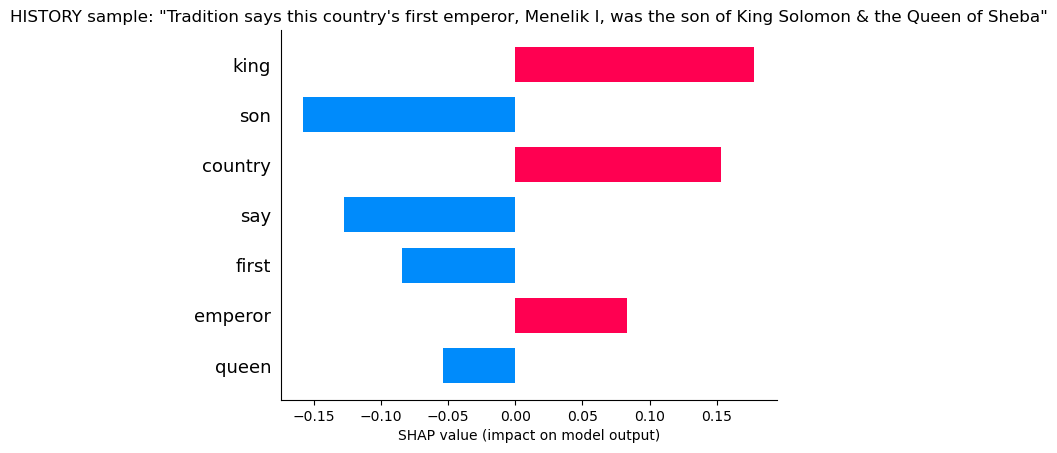

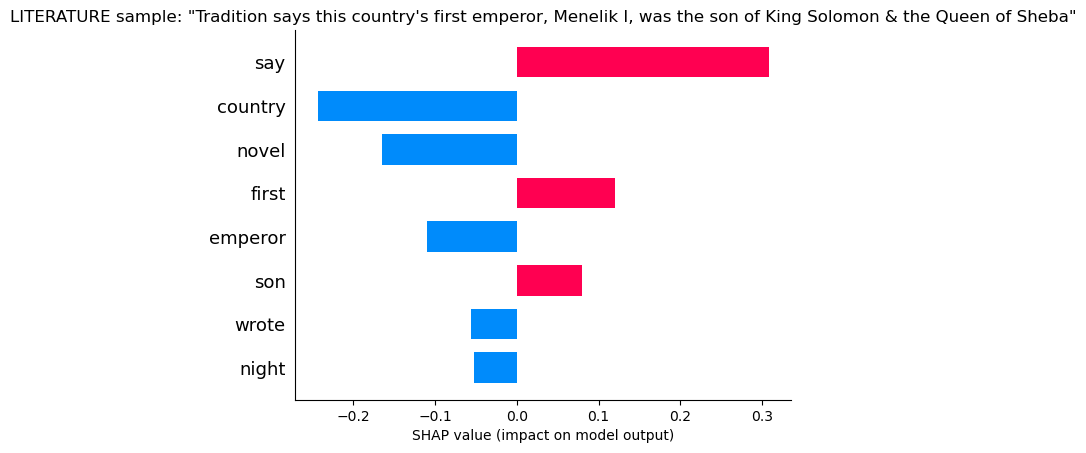

In [525]:
for feature in le.classes_:
    encoded = le.transform(['HISTORY'])[0]
    sample_index = np.where(y_test.cpu().numpy() == encoded)[0][32]
    shap_vals = shap_values[le.transform([feature])[0]][sample_index]
    use = shap_vals*[abs(shap_vals) > .05][0]
    shap.bar_plot(use,feature_names = feature_names,max_display = (abs(use) > 0).sum(),show = False)
    sentence  = df.loc[X_test_original.index[sample_index],'Question']
    plt.title(f'{feature} sample: "{sentence}"')
    plt.savefig(feature+'_one_sample_mult_feat_',bbox_inches='tight')
    plt.show()

In [523]:
print('True Label:',df.loc[X_test_original.index[sample_index]].Category)
probs = np.array(softmax(model(X_test[sample_index:sample_index+1]),dim=1).detach().cpu())[0]
print()
for category,prob in zip(le.classes_,probs):
    print(f'{round(prob*100,2)}% chance of being {category}')
print()
print('Modle Predicts: ', le.classes_[probs.argmax()])

True Label: HISTORY

14.71% chance of being ART
17.11% chance of being GEOGRAPHY
33.44% chance of being HISTORY
34.74% chance of being LITERATURE

Modle Predicts:  LITERATURE


The model is just barely wrong! With a little hyperparameter tuning, or simple tricks like adding in bi-grams, i'm sure it can figure it out!